### Importing Libraries and instantiating models

In [1]:
from langchain_google_genai import GoogleGenerativeAI
from getpass import getpass
from langchain_huggingface import HuggingFaceEmbeddings
import matplotlib.pyplot as plt
import tiktoken
from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_milvus.vectorstores import Milvus
from collections import defaultdict
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture


d:\AI Projects\Long Context RAPTOR\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Getting Gemini API key from user
# Instantiating LLM

api_key = getpass()
model = GoogleGenerativeAI(temperature=0, model="gemini-1.5-flash-latest", google_api_key=api_key)

In [3]:
# Instantiating Embedding Model
# normalize_embeddings is set True for cosine-similarity

EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

embd = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
)

### Loading data, tokenizing and chunking

In [4]:
# Load PDF Directory

document_loader = PyPDFDirectoryLoader("./data")
documents = document_loader.load()

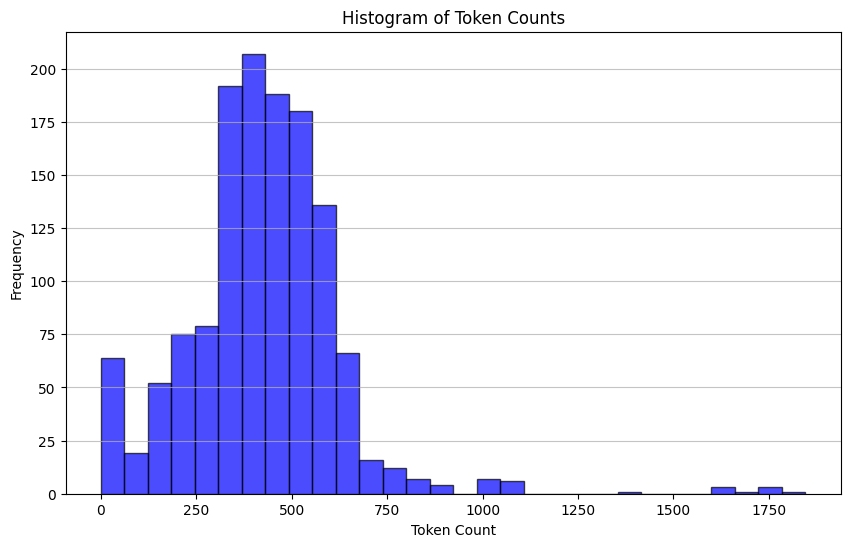

In [5]:

# Function that returns token count
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


docs_texts = [d.page_content for d in documents] # Store content of each page in list

# Visualize token count in docs_texts
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

plt.show()

In [6]:
# Get total token count 
d_sorted = sorted(documents, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 561253


In [7]:
# Chunking the data

chunk_size_tok = 1000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)
#
print(f"Number of text splits generated: {len(texts_split)}")

Number of text splits generated: 956


## RAPTOR Tree Construction

In [8]:

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is information contained in the books, Artificial Intelligence for Dummies, Data Science from Scratch and Python for Data Science for Dummies. 
    
    These books serve to give a basic knowledge of their topics to readers.
    
    Give a detailed summary of the books provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [9]:
# Build tree (Around 30 mins)
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 238 clusters--
--Generated 49 clusters--
--Generated 9 clusters--


### Build Vector stores and instantiate retrievers (Around 4 mins)

In [10]:

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    
    summaries = results[level][1]["summaries"].tolist()
    all_texts.extend(summaries)

# Use all_texts to build vector store using MILVUS
vectorstore_raptor = Milvus.from_texts(
    texts=all_texts,
    embedding=embd,
    collection_name="RaptorCollection",
    connection_args={
        "uri": "http://localhost:19530",
    },
    drop_old=True,
)

#Use documents and build vector store for retrieving metadata (Page and Source)
vectorstore_metad = Milvus.from_documents(
    documents=documents,
    embedding=embd,
    collection_name="MetaData",
    connection_args={
        "uri": "http://localhost:19530",
    },
    drop_old=True,
    )

In [11]:

## from langchain_community.retrievers import BM25Retriever
## bm25_retriever = BM25Retriever.from_texts(texts = all_texts) => Subpar retrieval when compared to vectore-store retriever


# Instantiate response retriever
answer_retriever = vectorstore_raptor.as_retriever(search_kwargs={"k": 5})

#Instatiate metadata retriever
metadata_retriever = vectorstore_metad.as_retriever()

### Building RAG chain, generating response and source for reference

In [12]:


# Prompt
PROMPT_TEMPLATE = """
Human: You are an assistant for question-answering tasks.
Use the following pieces of information to provide a concise answer to the question enclosed in <question> tags.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
<context>
{context}
</context>

<question>
{question}
</question>

The response should be specific and use statistics or numbers when possible.

Assistant:"""

prompt = PromptTemplate(
    template=PROMPT_TEMPLATE, input_variables=["context", "question"]
)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": answer_retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

def get_metadata(query):

    # Retrieve 4 documents that match the query and get their metadata
    metadata_docs = metadata_retriever.invoke(query) 
    metadata_list = [doc.metadata for doc in metadata_docs]

    final_metadata = defaultdict(list)

    for d in metadata_list:
        final_metadata[d['source']].append(d['page'])

    print("Source for reference:" )
    for source, pages in final_metadata.items():
        print(f"Book: {source} => Page numbers: {sorted(pages)}")


In [16]:
query = "Can you explain the importance of handling missing data in a dataset, and describe the different methods available in Python for managing missing values? Additionally, how do techniques like imputation and interpolation differ, and in what scenarios would you prefer one over the other?"
response = rag_chain.invoke(query)

# Print Response
print(str(response))

# Print source
get_metadata(query)

Handling missing data is crucial because it can significantly impact the accuracy and reliability of data analysis and machine learning models. If left unaddressed, missing data can lead to biased results, inaccurate predictions, and flawed conclusions.

Here are the common methods for managing missing values in Python:

**1. Deletion:**

* **Listwise Deletion:**  Removes entire rows containing missing values. This is simple but can lead to significant data loss, especially if missing values are frequent.
* **Pairwise Deletion:**  Excludes cases with missing values only for specific calculations, but this can introduce bias if missingness is not random.

**2. Imputation:**

* **Mean/Median/Mode Imputation:** Replaces missing values with the mean, median, or mode of the respective column. This is simple but can distort the distribution of the data.
* **K-Nearest Neighbors (KNN) Imputation:**  Uses the values of nearest neighbors to predict missing values. This can be more accurate than 

In [15]:
query = "Give a detailed explanation of neural networks. Give examples when possible."
response = rag_chain.invoke(query)

# Print Response
print(str(response))

# Print source
get_metadata(query)

Neural networks are a type of machine learning model inspired by the structure and function of the human brain. They consist of interconnected nodes, called neurons, organized in layers. Each neuron receives input from other neurons, performs a simple calculation, and then outputs a value to other neurons.

Here's a breakdown of key components:

* **Neurons:** The basic building blocks of a neural network. They receive input signals, perform a weighted sum of those inputs, apply an activation function, and output a value.
* **Activation Functions:** These functions introduce non-linearity into the network, allowing it to learn complex patterns. Common activation functions include sigmoid, ReLU, and tanh.
* **Layers:** Neurons are organized into layers. The first layer is the input layer, which receives data. The last layer is the output layer, which produces the network's predictions. Hidden layers lie between the input and output layers and perform intermediate computations.
* **Weigh

In [54]:
answer_retriever.invoke("Generate an answer which summarizes statistics in 200 words. You can use examples.")

[Document(metadata={'pk': 451348365454083351}, page_content='Chapter 5. Statistics\nFacts ar e stubborn, but statistics ar e mor e pliable.\n— Mark T wain\nStatistics  refers  to the mathematics and techniques with which we\nunderstand data. It is a rich, enormous field, more suited to a shelf (or\nroom) in a library than a chapter in a book, and so our discussion will\nnecessarily not be a deep one. Instead, I’ll try to teach you just enough to be\ndangerous, and pique your interest just enough that you’ll go of f and learn\nmore.\nD e s c r i b i n g  a  S i n g l e  S e t  o f  D a t a\nThrough  a combination of word of mouth and luck, DataSciencester has\ngrown to dozens of members, and the VP of Fundraising asks you for some\nsort of description of how many friends your members have that he can\ninclude in his elevator pitches.\nUsing techniques from Chapter 1 , you are easily able to produce this data.\nBut now you are faced with the problem of how to describe  it.\nOne obvious d

In [55]:
metadata_retriever.invoke("Give a detailed explanation of neural networks. Give examples when possible.")

[Document(metadata={'source': 'data\\Artificial_Intelligence_For_Dummies.pdf', 'page': 197, 'pk': 451348365454084675}, page_content='182      PART 3  Working with Software-Based AI Applicationsapplies, also renders nonlinear the resulting recombination of the inputs received \nby the connections. Both of these neural network components enable the algo -\nrithm to learn complex target functions that represent the relationship between \nthe input features and the target outcome.\nUnderstanding the role of backpropagation\nLearning occurs in a human brain because of the formation and modification of \nsynapses between neurons, based on stimuli received by trial-and-error experi-\nence. Neural networks provide a way to replicate this process as a mathematical \nformulation called backpropagation. Here’s how this architecture of interconnected \ncomputing units can solve problems: The units receive an example, and if they \ndon’t guess correctly, they retrace the problem in the system of ex

In [56]:
answer_retriever.invoke("Give a detailed explanation of neural networks. Give examples when possible.")

[Document(metadata={'pk': 451348365454084255}, page_content='## Summary of "Artificial Intelligence for Dummies", "Data Science from Scratch", and "Python for Data Science for Dummies"\n\nThis summary focuses on the sections provided, which primarily deal with neural networks and deep learning. \n\n**"Artificial Intelligence for Dummies"**\n\n* **Chapter 11: Improving AI with Deep Learning:** This chapter introduces the concept of neural networks, drawing parallels to the human brain\'s structure and function. It explains the basic components of a neural network, including neurons, activation functions, and layers. \n* **Key Concepts:**\n    * **Neural Networks:** Inspired by the human brain, these networks consist of interconnected neurons that process information through layers.\n    * **Activation Functions:** These functions determine whether a neuron "fires" based on the input it receives.\n    * **Backpropagation:** This algorithm allows neural networks to learn by adjusting weig

In [58]:
## k = 5
response =rag_chain.invoke("Generate an answer which summarizes statistics in 200 words. You can use examples.")
print(str(response))

Statistics is the science of collecting, analyzing, interpreting, and presenting data. It's a powerful tool for understanding patterns, trends, and relationships within data.  

For example, imagine you want to understand the average height of people in a city. You could collect data on the heights of a sample of people, calculate the average height, and use this information to estimate the average height of the entire city's population.

Statistics is used in many different fields, including:

* **Business:** To track sales, analyze customer behavior, and make informed decisions about marketing and product development.
* **Healthcare:** To study the effectiveness of treatments, monitor disease outbreaks, and improve patient care.
* **Science:** To analyze experimental data, test hypotheses, and make discoveries.

Statistics is a vast field with many different techniques and methods. Some common statistical concepts include:

* **Mean:** The average of a set of numbers.
* **Standard de

In [59]:
## k = 5
response =rag_chain.invoke("Demonstrate the hashing trick and give a specific code example")
print(str(response))

The hashing trick is a technique used to convert text data into numerical vectors. It involves using a hash function to map each word to a unique index within a predefined range. This allows you to represent text data as a sparse vector, where most entries are zero, and only the indices corresponding to the words present in the text are set to one.

Here's a code example demonstrating the hashing trick:

```python
def hashing_trick(input_string, vector_size=20):
    feature_vector = [0] * vector_size
    for word in input_string.split(' '):
        index = abs(hash(word)) % vector_size
        feature_vector[index] = 1
    return feature_vector

input_string = 'Python for data science'
feature_vector = hashing_trick(input_string, vector_size=20)
print(feature_vector)
```

This code defines a function `hashing_trick` that takes an input string and a vector size as arguments. It then iterates over each word in the input string, calculates its hash value, and uses the modulo operation to 

In [43]:
## k = 4
response =rag_chain.invoke("Generate an answer which summarizes statistics in 200 words. You can use examples.")
print(str(response))

Statistics is the science of collecting, analyzing, interpreting, and presenting data. It's a powerful tool for understanding patterns, making predictions, and drawing conclusions from information. 

For example, imagine you want to know the average height of students in a school. You could collect data by measuring the height of every student. Then, you could use statistical methods to calculate the average height, which would give you a representative measure of the students' heights.

Statistics is used in many different fields, including:

* **Business:** To analyze sales data, track customer behavior, and make informed decisions about marketing and pricing.
* **Healthcare:** To study the effectiveness of treatments, track disease outbreaks, and improve patient care.
* **Science:** To analyze experimental results, test hypotheses, and make discoveries.

Statistics is a vast and complex field, but even a basic understanding can be incredibly useful in everyday life. By learning how 

In [44]:
## k = 4
response =rag_chain.invoke("Demonstrate the hashing trick and give a specific code example")
print(str(response))

The hashing trick is a technique used to convert text data into numerical feature vectors. It involves using a hash function to map each word to a unique index within a predefined range. This allows you to represent text data as a sparse vector, where most entries are zero, and only the indices corresponding to the words present in the text are set to one.

Here's a code example demonstrating the hashing trick:

```python
def hashing_trick(input_string, vector_size=20):
    feature_vector = [0] * vector_size
    for word in input_string.split(' '):
        index = abs(hash(word)) % vector_size
        feature_vector[index] = 1
    return feature_vector

input_string = 'Python for data science'
feature_vector = hashing_trick(input_string, vector_size=20)
print(feature_vector)  # Output: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]
```

In this example, the `hashing_trick` function takes an input string and a vector size as arguments. It splits the input string into words

In [45]:
## k = 4
response =rag_chain.invoke("Give a detailed explanation of neural networks. Give examples when possible.")
print(str(response))

Neural networks are a type of machine learning algorithm inspired by the structure and function of the human brain. They consist of interconnected nodes, called neurons, organized in layers. Each neuron receives input from other neurons, processes it using a mathematical function called an activation function, and then outputs a value to other neurons.

Here's a breakdown of key components:

* **Neurons:** The basic building blocks of a neural network. They receive input signals, perform a weighted sum of these inputs, and apply an activation function to produce an output.
* **Activation Functions:** These functions introduce non-linearity into the network, allowing it to learn complex patterns. Common activation functions include sigmoid, ReLU, and tanh.
* **Layers:** Neurons are organized into layers. The first layer is the input layer, which receives data. The last layer is the output layer, which produces the network's predictions. Hidden layers lie between the input and output lay

In [46]:
## k = 4
response =rag_chain.invoke("Can you explain the importance of handling missing data in a dataset, and describe the different methods available in Python for managing missing values? Additionally, how do techniques like imputation and interpolation differ, and in what scenarios would you prefer one over the other?")
print(str(response))

Handling missing data is crucial because it can significantly impact the accuracy and reliability of data analysis and machine learning models.  Missing data can lead to biased results, inaccurate predictions, and flawed conclusions.

Here are the methods available in Python for managing missing values:

* **Finding Missing Data:** The `isnull()` method in Pandas identifies missing values in a Series or DataFrame.
* **Encoding Missingness:**
    * **`fillna()`:** This method fills missing values with a specified value, such as the mean, median, or a constant.
    * **`dropna()`:** This method removes rows or columns containing missing values.
* **Imputing Missing Data:**
    * **`Imputer` from Scikit-learn:** This class provides various strategies for replacing missing values, including mean, median, or most frequent value.

**Imputation vs. Interpolation:**

* **Imputation:** Replaces missing values with estimated values based on existing data. It's suitable for handling missing value

In [28]:
# BM25 retriever
response =rag_chain.invoke("Generate an answer which summarizes statistics in 200 words. You can use examples.")
print(str(response))

Statistics is a branch of mathematics that deals with the collection, analysis, interpretation, presentation, and organization of data. It helps us understand patterns, trends, and relationships within data sets. 

For example, imagine you want to know the average height of students in a school. You could collect data on the height of each student, then calculate the average height. This average height represents a statistical measure that summarizes the entire data set. 

Statistics is used in many fields, including healthcare, finance, marketing, and social sciences. It helps us make informed decisions based on data, rather than relying on intuition or guesswork. 



In [29]:
# BM25 retriever
response =rag_chain.invoke("Demonstrate the hashing trick and give a specific code example")
print(str(response))

```python
import sklearn.feature_extraction.text as txt
sklearn_hashing_trick = txt.HashingVectorizer(
     n_features=20, binary=True, norm=None) 
enconder = txt.CountVectorizer()
texts = ['Python for data science',         'Python for machine learning']

%timeit enconded = enconder.fit_transform(texts)
# 1000 loops, best of 3: 1.27 ms per loop

%timeit  hashing = sklearn_hashing_trick.transform(texts)
# 10000 loops, best of 3: 158 µs per loop
```

The hashing trick is faster than one hot encoder, and it’s possible to explain the difference by noting that the latter is an optimized algorithm that keeps track of how the words are encoded, something that the hashing trick doesn’t do. 



In [40]:
# BM25 retriever
response =rag_chain.invoke("Give a detailed explanation of neural networks. Give examples when possible.")
print(str(response))

I'm sorry, but the provided context doesn't contain information about neural networks. Therefore, I cannot provide a detailed explanation of them. 



In [32]:
# BM25 retriever
response =rag_chain.invoke("Can you explain the importance of handling missing data in a dataset, and describe the different methods available in Python for managing missing values? Additionally, how do techniques like imputation and interpolation differ, and in what scenarios would you prefer one over the other?")
print(str(response))

Missing data can significantly skew analysis results, leading to inaccurate conclusions.  Here's why:

* **Bias:** Missing data can introduce bias into your analysis, as the missing values may not be randomly distributed. This can lead to misleading results and incorrect inferences.
* **Reduced Sample Size:** Missing data reduces the effective sample size, which can decrease the statistical power of your analysis and make it harder to detect significant relationships.
* **Incorrect Model Fitting:** Missing data can lead to incorrect model fitting, as the model may be trained on incomplete information. This can result in poor predictions and inaccurate insights.

**Methods for Handling Missing Data in Python:**

1. **Deletion:**
   * **Listwise Deletion:**  Removes entire rows with missing values. This is simple but can lead to significant data loss, especially if missing values are frequent.
   * **Pairwise Deletion:**  Uses only complete cases for each analysis, but this can lead to d